<a href="https://colab.research.google.com/github/writeforfun/video-classification/blob/master/UCF5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
pip install keras_metrics

In [3]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
 
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import keras_metrics as km
 
 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
data_dir = "/content/drive/My Drive/Colab Notebooks/UCF50"
img_height , img_width = 64, 64
seq_len = 30
 
UCF15 = os.listdir("/content/drive/My Drive/Colab Notebooks/UCF15")
classes = []
for item in UCF15:
  if item == ".DS_Store":
    pass
  else:
    classes.append(item)
classes = classes[0:5] 
classes

Using TensorFlow backend.


['Billiards', 'GolfSwing', 'BaseballPitch', 'HulaHoop', 'Fencing']

In [4]:
#  Creating frames from videos
 
def frames_extraction(video_path):
    frames_list = []
     
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable 
    count = 1
 
    while count <= seq_len: 
         
        success, image = vidObj.read() 
        if success:
            image = cv2.resize(image, (img_height, img_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break
 
            
    return frames_list

In [5]:
def create_data(input_dir):
    X = []
    Y = []
     
#     classes_list = os.listdir(input_dir)
     
    for c in classes:
        
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            if len(frames) == seq_len:
                y = [0]*len(classes)
                y[classes.index(c)] = 1
                X.append(frames)
                Y.append(y)
     
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

In [6]:
X, Y = create_data(data_dir)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=0)

In [7]:
model = Sequential()
model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3), data_format = "channels_last", input_shape = (seq_len, img_height, img_width, 3)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation="relu",name="dense1"))
model.add(Dropout(0.3))
model.add(Dense(len(classes), activation = "softmax",name="dense2"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 62, 62, 64)        154624    
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 246016)            0         
_________________________________________________________________
dense1 (Dense)               (None, 256)               62980352  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense2 (Dense)               (None, 5)                 1285      
Total params: 63,136,261
Trainable params: 63,136,261
Non-trainable params: 0
__________________________________________

In [8]:
model.layers[2].output

<tf.Tensor 'flatten_1/Reshape:0' shape=(None, None) dtype=float32>

In [9]:
opt = keras.optimizers.SGD(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]

In [10]:
history = model.fit(x = X_train, y = y_train, epochs=20, batch_size = 8 , shuffle=True, validation_split=0.2, callbacks=callbacks)


Train on 433 samples, validate on 109 samples
Epoch 1/20
433/433 [==============================] - 23s 54ms/step - loss: 1.5513 - accuracy: 0.4065 - val_loss: 1.4257 - val_accuracy: 0.4128
Epoch 2/20
433/433 [==============================] - 17s 38ms/step - loss: 0.9503 - accuracy: 0.6282 - val_loss: 0.7199 - val_accuracy: 0.7706
Epoch 3/20
433/433 [==============================] - 16s 38ms/step - loss: 0.6605 - accuracy: 0.7552 - val_loss: 1.0516 - val_accuracy: 0.5688
Epoch 4/20
433/433 [==============================] - 16s 37ms/step - loss: 0.4168 - accuracy: 0.8614 - val_loss: 0.4136 - val_accuracy: 0.8349
Epoch 5/20
433/433 [==============================] - 16s 38ms/step - loss: 0.3323 - accuracy: 0.8730 - val_loss: 0.2781 - val_accuracy: 0.8807
Epoch 6/20
433/433 [==============================] - 16s 38ms/step - loss: 0.1584 - accuracy: 0.9700 - val_loss: 0.2692 - val_accuracy: 0.9083
Epoch 7/20
433/433 [==============================] - 16s 38ms/step - loss: 0.0900 - accur

In [36]:
y_train

array([1, 0, 2, 2, 4, 2, 3, 2, 2, 4, 0, 3, 2, 3, 4, 0, 1, 1, 4, 1, 0, 2,
       0, 3, 3, 0, 4, 2, 1, 3, 0, 3, 2, 4, 4, 1, 0, 2, 3, 3, 4, 0, 3, 0,
       4, 3, 2, 4, 1, 4, 3, 2, 3, 3, 2, 2, 3, 0, 1, 0, 3, 4, 2, 1, 1, 2,
       0, 0, 4, 3, 3, 4, 0, 0, 0, 1, 2, 1, 1, 2, 2, 1, 2, 3, 1, 4, 0, 3,
       1, 0, 0, 0, 3, 0, 4, 4, 4, 1, 1, 0, 0, 3, 2, 2, 1, 4, 2, 1, 1, 3,
       0, 3, 4, 3, 4, 4, 0, 1, 1, 0, 1, 2, 1, 1, 1, 2, 2, 0, 0, 3, 0, 2,
       3, 2, 0, 3])

In [34]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)#模擬出來的
y_test = np.argmax(y_test, axis = 1)#本來就有的

AxisError: ignored

In [37]:
y_train = np.argmax(y_train, axis = 1)

In [ ]:
y_train

In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      0.85      0.92        27
           2       0.93      1.00      0.97        28
           3       0.90      1.00      0.95        28
           4       0.90      0.86      0.88        22

    accuracy                           0.95       136
   macro avg       0.95      0.94      0.94       136
weighted avg       0.95      0.95      0.95       136



In [39]:
dense1 = Model(inputs=model.input, outputs=model.get_layer('dense1').output)
# dense1_data = dense1.predict(X_test) 
dense1_data = dense1.predict(X_train) 
dense1_data.shape

(542, 256)

In [40]:
from sklearn.decomposition import PCA
import pandas as pd                     
pca = PCA(n_components=2)  # 把維度降至2維
# 進行PCA降維
X_pca = pca.fit_transform(dense1_data)
# 生成降維後的dataframe
X_pca_frame = pd.DataFrame(X_pca, columns=['pca_1', 'pca_2'])  
X_pca_frame.head()


,pca_1,pca_2
0,5.156900,-2.942635
1,3.985385,-2.514742
2,-3.570418,5.880989
3,-9.509485,-6.727727
4,-0.406165,5.475139


In [41]:
pca.explained_variance_ratio_

array([0.4013    , 0.21609394], dtype=float32)

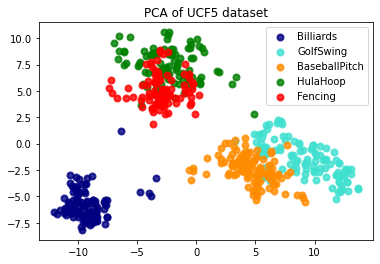

In [42]:
import matplotlib.pyplot as plt

plt.figure()
colors = ['navy', 'turquoise', 'darkorange','green','red']
lw = 2
for color, i, target_name in zip(colors, [0, 1, 2, 3, 4], np.array(classes)):
    plt.scatter(X_pca[y_train == i, 0], X_pca[y_train == i, 1], color=color, alpha=.8, lw=lw,# Y2要numpy array
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of UCF5 dataset')
plt.show()

calinski_harabaz_score with k=5 is 2007.647440261231
calinski_harabaz_score with k=6 is 1861.5013922678443
calinski_harabaz_score with k=7 is 1814.9837767816014
calinski_harabaz_score with k=8 is 1808.4851308159293


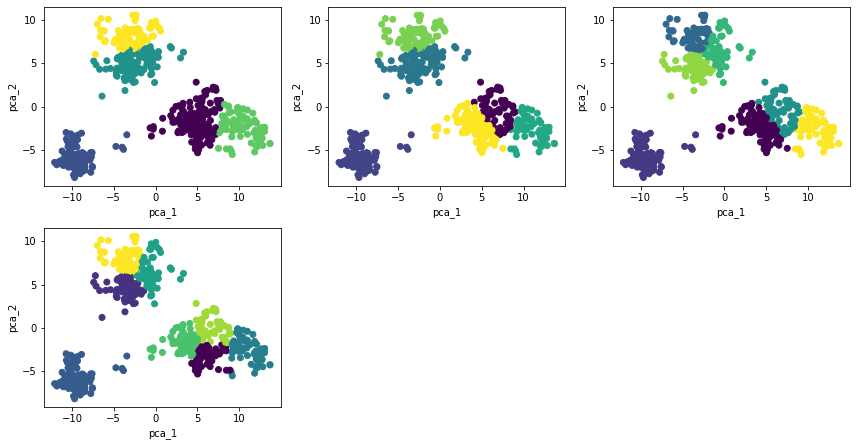

In [47]:
from sklearn.cluster import KMeans
from sklearn import metrics
d = {}
fig_reduced_data = plt.figure(figsize=(12, 12)) #畫圖之前先設置figure，此函数=設置一塊自定義大小的畫布讓之後的圖形印在這塊畫布上
for k in range(5, 9):
    est = KMeans(n_clusters=k, random_state=111)
    y_pred_kmeans = est.fit_predict(X_pca) #作用到降維後的數據上
    # ====評估不同k值效果====

    # X_pca_frame：表示要cluster的樣本數據，一般如（samples，features）的格式。y_pred：即cluster後得到的label，如（samples，）的格式
    calinski_harabaz_score = metrics.calinski_harabasz_score(X_pca_frame, y_pred_kmeans)  
    d.update({k: calinski_harabaz_score})
    print('calinski_harabaz_score with k={0} is {1}'.format(k, calinski_harabaz_score))  # CH score的数值越大越好
    #生成2D圖，每個樣本點的坐標分别是兩個主成分的值
    ax = plt.subplot(4, 3, k-1) #將設置的畫布大小分成幾個部分，表示4(row)x3(col),k-4表示選擇圖形輸出的區域在第k-1塊，參數必須在“rowXcol”範圍
    ax.scatter(X_pca_frame.pca_1, X_pca_frame.pca_2, c=y_pred_kmeans)  # pca_1、pca_2為輸入數據，c表示顏色序列
    ax.set_xlabel('pca_1')
    ax.set_ylabel('pca_2')
    plt.tight_layout()